Dataset
https://www.kaggle.com/datasets/yasserh/amazon-product-reviews-dataset

In [3]:
# 1. Load Data
import pandas as pd

# Load the Amazon Fine Food Reviews dataset
df = pd.read_csv("amazon_product_review.csv")
df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


In [4]:
print(df.columns)


Index(['id', 'asins', 'brand', 'categories', 'colors', 'dateAdded',
       'dateUpdated', 'dimension', 'ean', 'keys', 'manufacturer',
       'manufacturerNumber', 'name', 'prices', 'reviews.date',
       'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'sizes',
       'upc', 'weight'],
      dtype='object')


In [5]:
df = df[['reviews.text', 'reviews.rating']].dropna()
df.columns = ['Text', 'Score']

Preprocess: Tokenize, Lemmatize, Remove Stopwords

In [6]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download resources
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor', 'never'}
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", '', text)  # remove links
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['Cleaned_Text'] = df['Text'].apply(clean_text)
df['Cleaned_Text'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,Cleaned_Text
0,initially trouble deciding paperwhite voyage r...
1,allow preface little history casual reader own...
2,enjoying far great reading original fire since...
3,bought one first paperwhites pleased constant ...
4,say upfront dont like coroporate hermetically ...


Convert Text to TF-IDF Vectors

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['Cleaned_Text'])

# Converting score to sentiment label
def score_to_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

df['Sentiment'] = df['Score'].apply(score_to_sentiment)
y = df['Sentiment']


Train and Test Split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Model Training (Logistic Regression)

In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

Evaluation

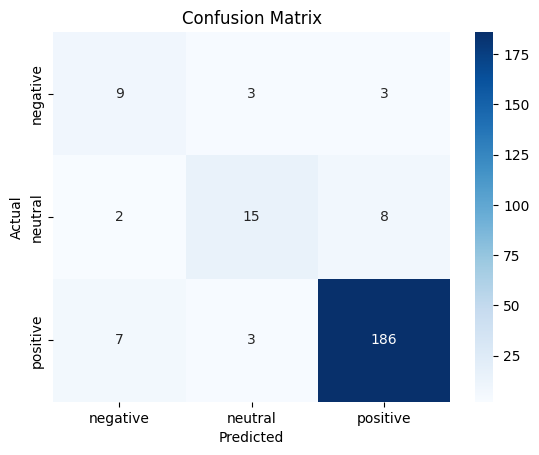

              precision    recall  f1-score   support

    negative       0.50      0.60      0.55        15
     neutral       0.71      0.60      0.65        25
    positive       0.94      0.95      0.95       196

    accuracy                           0.89       236
   macro avg       0.72      0.72      0.71       236
weighted avg       0.89      0.89      0.89       236



In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


y_pred = model.predict(X_test)

# Encoding the target variable to get class labels for plotting
le = LabelEncoder()
le.fit(df['Sentiment'])


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=le.classes_))

Visualization

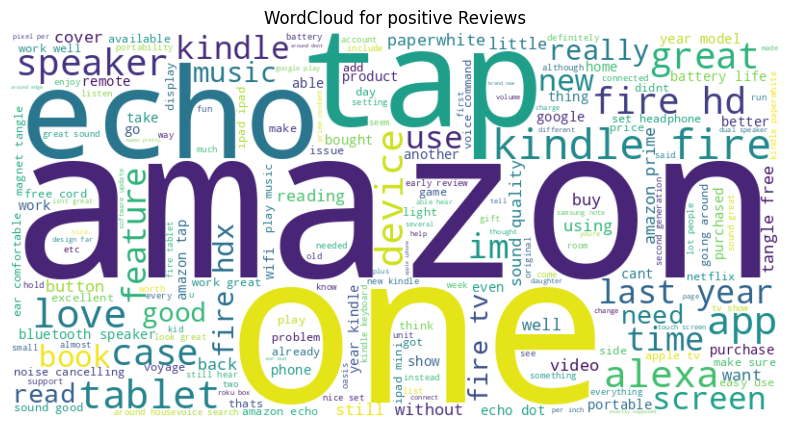

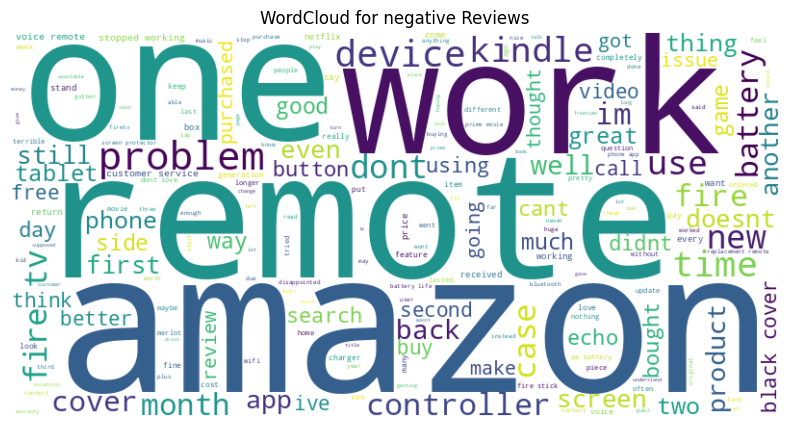

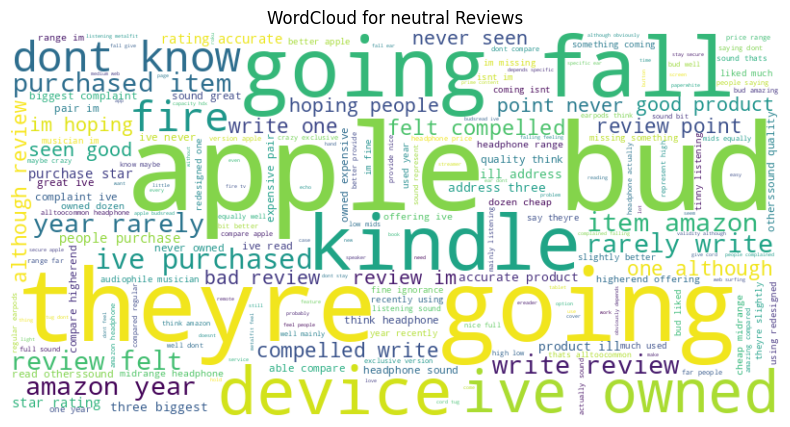

In [11]:
# WordCloud Visualization
from wordcloud import WordCloud

def plot_wordcloud(sentiment_label):
    text = " ".join(df[df['Sentiment'] == sentiment_label]['Cleaned_Text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {sentiment_label} Reviews")
    plt.show()

plot_wordcloud('positive')
plot_wordcloud('negative')
plot_wordcloud('neutral')

In [12]:
# Saving model for Streamlit app
import pickle
with open("model.pkl", "wb") as f:
    pickle.dump((model, vectorizer, le), f)